# Pruebas estadísicas - Complemento a la predicción

**Autor:** Jazna Meza Hidalgo

**Correo Electrónico:** ja.meza@profesor.duoc.cl

**Fecha de Creación:** Diciembre de 2024  
**Versión:** 1.0  

---

## Descripción

Este notebook ofrece un complemento al trabajo de la predicción del monto de los costos médicos.

Realiza test estadísticos que respaldan y amplian los hallazgos de la matroz de correlación.

Las pruebas estadísticas que se realizan son:

1. Prueba t de Student para comparar medias.
2. Análisis de varianza ANOVA
3. Pruebas de correlación para variables continuas
4. Pruebas de normalidad (Shapizo-Wilk)
---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.9. A continuación se listan las bibliotecas necesarias:

- pandas (>=1.1.0)
- numpy (1.26.4)
- matplotlib (3.7.1)
- seaborn (0.13.1)

Para verificar la versión instalada ejecutar usando el siguiente comando, usando la librería de la cual quieres saber la versión:

```bash
import pandas as pd
print(pd.__version__)
````

In [17]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, f_oneway, pearsonr, spearmanr, shapiro
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
!wget https://www.dropbox.com/s/6xn8hxmo16f25qc/insurance.csv

--2024-12-30 19:42:52--  https://www.dropbox.com/s/6xn8hxmo16f25qc/insurance.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6057:18::a27d:d12
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/unto7vjrswe6u4w1nukvx/insurance.csv?rlkey=yr81nii85hmym91r9qdpzh76l [following]
--2024-12-30 19:42:53--  https://www.dropbox.com/scl/fi/unto7vjrswe6u4w1nukvx/insurance.csv?rlkey=yr81nii85hmym91r9qdpzh76l
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca3796a19c97436e3f4699081f1.dl.dropboxusercontent.com/cd/0/inline/ChR_45uHC6VAbQ_7jqhNhwT1SWrJKmsIW2iAVJQ50v0MWQ-cQgMaZYz7Vfw_h9uS6G0vVi8EKQHK3gkH-kiYUnnU0aElZVqyPZCle5u7QVlD1ah1aSpX_QCwmLctBBvjeqzc94gvnNO70gKhSPf1Nu7c/file# [following]
--2024-12-30 19:42:53--  https://uca3796a19c97436e3f4699081f1.dl.dropboxusercontent.com/cd/0/inlin

In [3]:
data_frame = pd.read_csv("insurance.csv")
data_frame

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [4]:
data_frame = data_frame.drop_duplicates()

In [5]:
data_x = pd.get_dummies(data_frame[["sex", "region", "smoker"]], prefix = ["sex", "region", "smoker"])
data_x.head()

,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,smoker_no,smoker_yes
0,True,False,False,False,False,True,False,True
1,False,True,False,False,True,False,True,False
2,False,True,False,False,True,False,True,False
3,False,True,False,True,False,False,True,False
4,False,True,False,True,False,False,True,False


In [6]:
data_x = pd.concat([
    data_frame.drop(["sex", "region", "smoker"], axis = 1),
    data_x
], axis = 1)
data_x.head()

,age,bmi,children,charges,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,smoker_no,smoker_yes
0,19,27.900,0,16884.92400,True,False,False,False,False,True,False,True
1,18,33.770,1,1725.55230,False,True,False,False,True,False,True,False
2,28,33.000,3,4449.46200,False,True,False,False,True,False,True,False
3,33,22.705,0,21984.47061,False,True,False,True,False,False,True,False
4,32,28.880,0,3866.85520,False,True,False,True,False,False,True,False


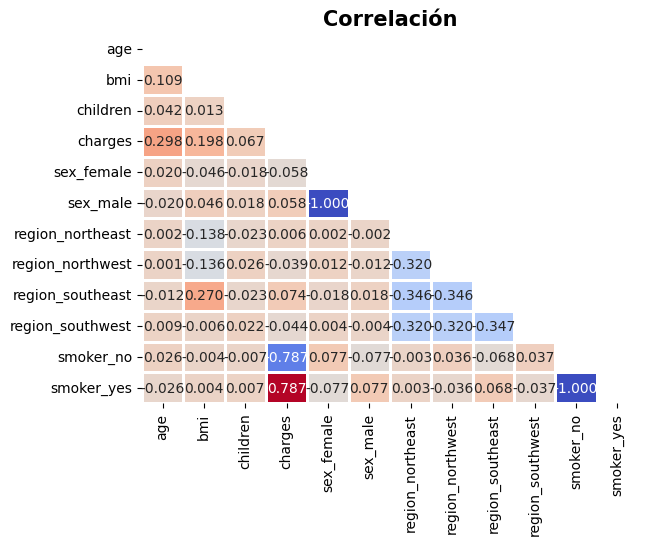

In [7]:
corrMatrix = data_x.corr(numeric_only=True)
mask = np.triu(corrMatrix)
sns.heatmap(corrMatrix,
            annot=True,
            fmt='.3f',
            cmap='coolwarm',
            mask=mask,
            linewidths=1,
            cbar=False)
plt.title("Correlación", fontsize=15, fontweight="bold")
plt.show()

In [8]:
# Variables clave
categorical_vars = ['sex_female', 'sex_male', 'smoker_no', 'smoker_yes', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']
continuous_vars = ['age', 'bmi']
target = 'charges'

# Prueba t de Student

**Objetivo.** Evaluar si hay diferencias significativas en los costos (charges) entre los grupos binarios de variables como smoker y sex.

**Ejemplo**

+ Comparar los costos medios entre fumadores (smoker_yes) y no fumadores (smoker_no).
+ Comparar los costos medios entre hombres (sex_male) y mujeres (sex_female).

**Hipótesis**

+ H0: No hay diferencias significativas entre los grupos (las medias de charges son iguales).
+ H1: Hay diferencias significativas entre los grupos (las medias de *charges* son diferentes).

In [11]:
print("Prueba t de Student: smoker vs. charges")
smoker_yes = data_x[data_x['smoker_yes'] == 1][target]
smoker_no = data_x[data_x['smoker_no'] == 1][target]
t_stat, p_val_ttest = ttest_ind(smoker_yes, smoker_no)
print(f"T-statistic: {t_stat:.2f}, p-value: {p_val_ttest:.9f}")


Prueba t de Student: smoker vs. charges
T-statistic: 46.64, p-value: 0.000000000




---
**Interpretación**


---

Un T-statistic de 46.64 y un p-value extremadamente bajo (prácticamente 0) indican que existe una diferencia estadísticamente significativa entre los costos médicos (charges) de fumadores y no fumadores.

**T-statistic (46.64)**

+ Este valor mide cuántas desviaciones estándar separan las medias de los dos grupos (fumadores y no fumadores).
+ Un valor tan alto sugiere una gran diferencia entre las medias de los costos médicos de los dos grupos.

**p-value (prácticamente 0)**

+ Un p-value tan pequeño significa que la probabilidad de observar una diferencia tan grande (o mayor) entre las medias debido al azar es prácticamente nula.

+ Si usamos un nivel de significancia típico (por ejemplo, α=0.05), se rechaza la hipótesis nula ($𝐻_0$).

**Hipótesis en la prueba t de Student**

+ $𝐻_0$ (hipótesis nula): no hay diferencia en los costos médicos entre fumadores y no fumadores (las medias son iguales).
+ $𝐻_1$ (hipótesis alternativa): existe una diferencia en los costos médicos entre fumadores y no fumadores (las medias son diferentes).

**Conclusión**
Se rechaza $𝐻_0$. Existe evidencia estadística sólida de que los fumadores y no fumadores tienen costos médicos significativamente diferentes.

**Implicaciones prácticas**

+ Diferencia clara en los costos. Los fumadores tienen costos médicos notablemente más altos, lo que indica que fumar tiene un impacto considerable en los gastos médicos.

+ Tamaño del efecto. Para cuantificar la magnitud de esta diferencia, se puede calcular la d de Cohen (medida del tamaño del efecto). **Un valor de d mayor a 0.8 indica un tamaño del efecto grande.**



In [13]:
mean_yes = np.mean(smoker_yes)
mean_no = np.mean(smoker_no)
std_combined = np.sqrt(((np.std(smoker_yes)**2) + (np.std(smoker_no)**2)) / 2)
cohen_d = (mean_yes - mean_no) / std_combined
print(f"Cohen's d: {cohen_d:.2f}")

Cohen's d: 2.57


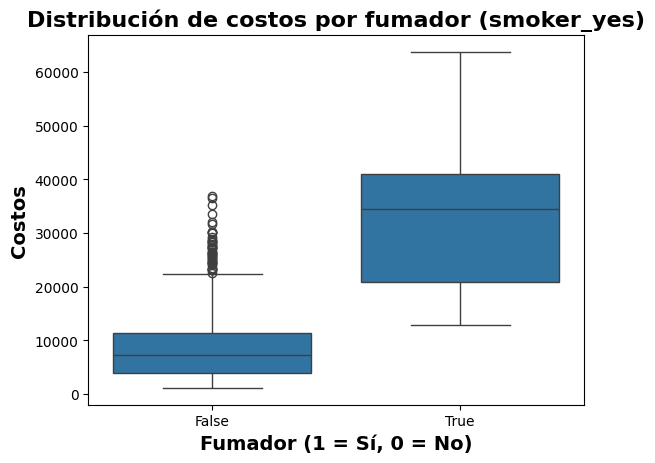

In [15]:
sns.boxplot(x='smoker_yes', y='charges', data=data_x)
plt.title('Distribución de costos por fumador (smoker_yes)', fontsize=16, fontweight="bold")
plt.xlabel('Fumador (1 = Sí, 0 = No)', fontsize=14, fontweight="bold")
plt.ylabel('Costos', fontsize=14, fontweight="bold")
plt.show()

# Test de ANOVA

**Objetivo.** Evaluar si los costos (charges) difieren significativamente entre las regiones (region_northeast, region_northwest, etc.).

**Hipótesis**
+ $H_0$: Las medias de charges son iguales en todas las regiones.
+ $H_1$: Al menos una región tiene una media de charges diferente.


In [20]:
# Identificar las columnas dummies relacionadas con la región
dummies = [col for col in data_x.columns if col.startswith('region_')]

# Reconstruir la variable categórica original
data_x['region'] = data_x[dummies].idxmax(axis=1).str.replace('region_', '')

# Verificar la nueva columna
print(data_x['region'].head())

0    southwest
1    southeast
2    southeast
3    northwest
4    northwest
Name: region, dtype: object


In [22]:
# Agrupar los valores de charges por región

grouped_regions = [data_x[data_x['region'] == region]['charges'] for region in data_x['region'].unique()]

# Calcular ANOVA
f_stat, p_value = f_oneway(*grouped_regions)
print("Prueba ANOVA: region vs. charges")
print(f"F-statistic: {f_stat:.2f}, p-value: {p_value:.4f}")

Prueba ANOVA: region vs. charges
F-statistic: 2.93, p-value: 0.0328


---

**Interpretaciones**

---

**F-statistic (2.93)**

+ El estadístico F mide la relación entre la variabilidad explicada por las diferencias entre las regiones y la variabilidad dentro de las regiones.
+ Un valor más alto de F indica que las diferencias entre las medias de las regiones son más grandes en comparación con la variabilidad interna.

**p-value (0.0328)**

Dado que el p-value es menor que el nivel de significancia típico (𝛼=0.05), se rechaza la hipótesis nula ($𝐻_0$).

**Hipótesis en ANOVA**

+ $𝐻_0$: Las medias de charges son iguales para todas las regiones.
+ $𝐻_1$: Al menos una región tiene una media de charges diferente.

**Conclusión**

Existe evidencia estadística de que los costos médicos (charges) varían según la región.

**Influencia de la región**

La región parece tener un efecto estadísticamente significativo en los costos médicos. Esto sugiere que factores geográficos o relacionados con la región pueden influir en los gastos médicos.

**Identificación de diferencias específicas**

La prueba ANOVA indica que hay diferencias significativas entre las regiones, pero no especifica cuáles regiones difieren. Es necesario realizar una prueba post hoc, como Tukey HSD, para identificar las diferencias.



In [23]:
tukey = pairwise_tukeyhsd(endog=data_x['charges'], groups=data_x['region'], alpha=0.05)
print(tukey)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1    group2   meandiff  p-adj    lower      upper   reject
-----------------------------------------------------------------
northeast northwest  -955.5437 0.7457 -3397.7353  1486.648  False
northeast southeast  1329.0269 0.4746 -1045.1237 3703.1776  False
northeast southwest -1059.4471 0.6793 -3499.7595 1380.8652  False
northwest southeast  2284.5706 0.0643     -89.58 4658.7212  False
northwest southwest  -103.9035 0.9995 -2544.2158 2336.4088  False
southeast southwest -2388.4741 0.0477 -4760.6915  -16.2567   True
-----------------------------------------------------------------


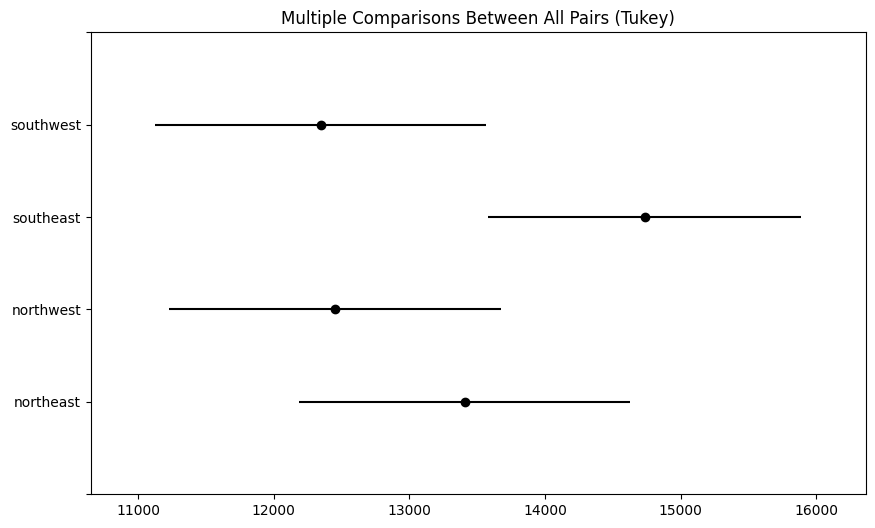

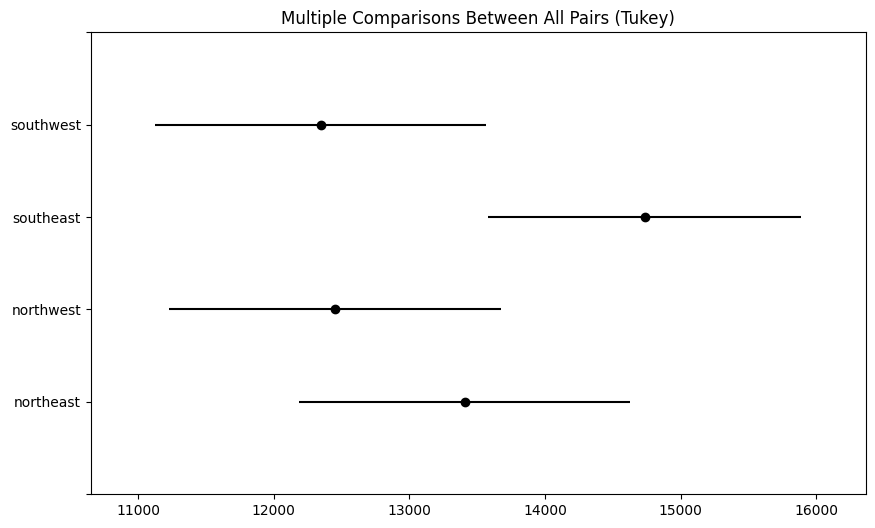

In [24]:
# Visualización del resumen
tukey.plot_simultaneous()

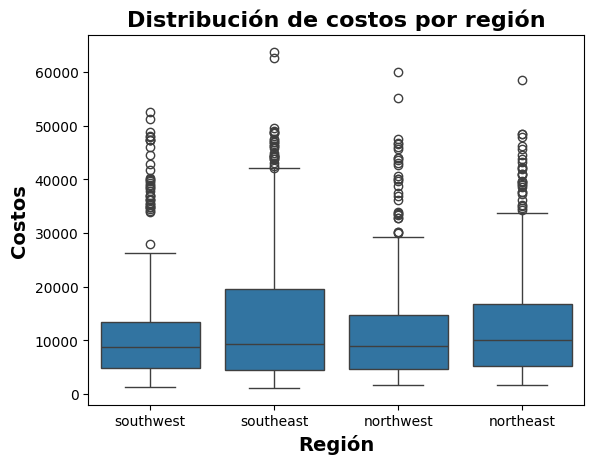

In [25]:
sns.boxplot(x='region', y='charges', data=data_x)
plt.title('Distribución de costos por región', fontsize=16, fontweight="bold")
plt.xlabel('Región', fontsize=14, fontweight="bold")
plt.ylabel('Costos', fontsize=14, fontweight="bold")
plt.show()

---
**COMENTARIO FINAL**

---
Este resultado sugiere que factores asociados a la ubicación geográfica (como acceso a servicios médicos, diferencias en costos de vida, o patrones de salud regionales) pueden influir en los costos médicos. Esto podría ser relevante para políticas de salud o estudios sobre desigualdades regionales.

# Pruebas de correlación

+ Usar correlación de Pearson para confirmar la relación entre variables continuas como age o bmi con charges.
+ Si los datos no cumplen con la normalidad, usar correlación de Spearman como alternativa.


In [29]:
print("Correlación (Pearson y Spearman): variables continuas vs. charges")
for variable in continuous_vars:
    pearson_corr, p_val_pearson = pearsonr(data_x[variable], data_x[target])
    spearman_corr, p_val_spearman = spearmanr(data_x[variable], data_x[target])
    print(f"{variable} - Pearson: {pearson_corr:.2f} (p={p_val_pearson:.4f}), Spearman: {spearman_corr:.2f} (p={p_val_spearman:.4f})")


Correlación (Pearson y Spearman): variables continuas vs. charges
age - Pearson: 0.30 (p=0.0000), Spearman: 0.53 (p=0.0000)
bmi - Pearson: 0.20 (p=0.0000), Spearman: 0.12 (p=0.0000)


---
**Interpretaciones**

---

**Correlación entre age y charges**

**Pearson: 0.30 (p=0.0000)**

Esto indica una correlación positiva moderada entre la edad y los cargos médicos. A medida que aumenta la edad, los cargos médicos tienden a aumentar.

El p-valor (0.0000) indica que la correlación es estadísticamente significativa.

**Spearman: 0.53 (p=0.0000)**

Esto indica una correlación positiva más fuerte desde una perspectiva no lineal. Spearman evalúa relaciones monótonas (donde los valores aumentan o disminuyen consistentemente, aunque no sea lineal). Esto sugiere que, aunque la relación entre edad y cargos médicos no sea perfectamente lineal, hay una tendencia clara de que los cargos aumentan con la edad.

El p-valor confirma la significancia estadística de esta relación.

**Conclusión sobre age**

La edad tiene un impacto significativo en los cargos médicos, y esta relación es más fuerte al analizarla desde una perspectiva no lineal (Spearman). Esto puede reflejar que, a medida que las personas envejecen, tienden a requerir más atención médica y, por ende, sus cargos aumentan.

**Correlación entre bmi y charges**

**Pearson: 0.20 (p=0.0000)**

Esto indica una correlación positiva débil entre el índice de masa corporal (BMI) y los cargos médicos. A medida que aumenta el BMI, los cargos médicos tienden a aumentar, aunque la relación no es tan fuerte como en el caso de la edad.

El p-valor indica que esta correlación es estadísticamente significativa.
Spearman: 0.12 (p=0.0000)

Esto indica una correlación aún más débil desde una perspectiva no lineal. Esto sugiere que el impacto del BMI en los cargos médicos es menor y puede no ser constante en todos los rangos de BMI.

El p-valor confirma la significancia estadística.

**Conclusión sobre BMI**

Aunque el BMI tiene una relación positiva con los cargos médicos, su impacto es mucho menor en comparación con la edad. Esto podría reflejar que el BMI por sí solo no es un fuerte determinante de los cargos médicos, aunque podría interactuar con otras variables, como la presencia de comorbilidades.

**Comparación entre Pearson y Spearman**

La correlación de Pearson mide relaciones lineales, mientras que Spearman mide relaciones monótonas (que no necesariamente son lineales).

En el caso de age, la diferencia entre Pearson (0.30) y Spearman (0.53) sugiere que la relación entre edad y cargos médicos podría no ser completamente lineal, pero sí consistente en su tendencia creciente.

Para BMI, las correlaciones de Pearson y Spearman son más cercanas (0.20 vs. 0.12), lo que indica que la relación, aunque débil, es principalmente lineal.


**Impacto de la edad**

La edad es una variable significativa y relevante para predecir los cargos médicos. Esto sugiere que las personas mayores tienden a incurrir en mayores gastos médicos, probablemente debido a un aumento en la frecuencia de enfermedades relacionadas con la edad.

**Impacto del BMI**

El BMI tiene un impacto menor, pero aún significativo. Esto podría reflejar que el índice de masa corporal, aunque relevante para ciertos problemas de salud, no explica tanto la variabilidad en los cargos médicos como la edad.

**Recomendación**

Considerar la edad como una de las variables más importantes en el modelo predictivo.

Evaluar la interacción del BMI con otras variables, como el hábito de fumar o la presencia de enfermedades crónicas, para entender mejor su impacto.

# Prueba de normalidad (Shapiro-Wilk)

In [28]:
print("Prueba de normalidad (Shapiro-Wilk): charges")
stat, p_val_shapiro = shapiro(data_x[target])
print(f"Estadístico: {stat:.2f}, p-value: {p_val_shapiro:.9f}")

Prueba de normalidad (Shapiro-Wilk): charges
Estadístico: 0.81, p-value: 0.000000000


---
**Comentarios**

---

El resultado de la prueba de normalidad Shapiro-Wilk indica si los datos de la variable *charges* siguen una distribución normal.

**Estadístico: 0.81**

Este valor mide la desviación de los datos respecto a una distribución normal. Cuanto más cercano esté a 1, más se asemejan los datos a una distribución normal.

**p-valor: 0.000000000**

Este valor se utiliza para tomar la decisión sobre la hipótesis nula. La hipótesis nula de la prueba Shapiro-Wilk es:

$H_0$: Los datos de charges provienen de una distribución normal.

Si el p-valor es menor que un umbral común (como 0.05), se rechaza la hipótesis nula, lo que indica que los datos no tienen una distribución normal.

Dado que el p-valor es mucho menor que 0.05, es posible concluir que los datos de *charges* no siguen una distribución normal. Esto tiene implicaciones importantes para el análisis estadístico:

**Elección de pruebas estadísticas**

Muchas pruebas estadísticas (como ANOVA o la prueba t de Student) asumen que los datos siguen una distribución normal. Si esta suposición no se cumple, los resultados de estas pruebas podrían ser poco confiables.

En este caso, se debería considerar usar pruebas no paramétricas, que no requieren normalidad en los datos. Por ejemplo:

+Prueba de Kruskal-Wallis como alternativa a ANOVA.
+Prueba de Mann-Whitney U como alternativa a la prueba t de Student.

**Transformación de datos**

Si es necesario utilizar métodos que asuman normalidad, se podría transformar los datos para acercarlos a una distribución normal. Algunas transformaciones comunes incluyen:

+Transformación logarítmica (log(x)).
+Transformación de raíz cuadrada (sqrt(x)).
+Transformación Box-Cox (requiere valores positivos).

**Implicaciones en el modelo predictivo**

Si se van a construir modelos predictivos (como regresión lineal o árboles de decisión, que justamente es el caso), la falta de normalidad en la variable objetivo podría afectar el rendimiento de los modelos basados en suposiciones lineales.

